In [1]:
#creating the attention neural network
import tensorflow as tf
import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [2]:
dataset = pd.read_csv('complete_dataset.csv')

In [3]:
X = dataset.drop(['Country','Drought', 'Extreme temperature', 'Flood', 'Landslide', 'Storm', 'Total Disasters', 'Wildfire'], axis=1)
Y = dataset[['Total Disasters']].astype(np.float32)

In [4]:
# Scale the features
scaler_X = MinMaxScaler(feature_range=(0, 1))
X_scaled = scaler_X.fit_transform(X)

# Scale the target
scaler_y = MinMaxScaler(feature_range=(0, 1))
y_scaled = scaler_y.fit_transform(Y)

In [5]:
# Function to create sequences by country
def create_sequences_by_country(X, y, n_steps, data):
    Xs, ys = [], []
    countries = data['Country'].unique()
    for country in countries:
        country_indices = data[data['Country'] == country].index
        country_data_X = X[country_indices]
        country_data_y = y[country_indices]
        for i in range(len(country_data_X) - n_steps):
            Xs.append(country_data_X[i:(i + n_steps)])
            ys.append(country_data_y[i + n_steps])
    return np.array(Xs), np.array(ys).reshape(-1, 1)

n_steps = 1  # Using 3 years of data to predict the next year
X_seq, y_seq = create_sequences_by_country(X_scaled, y_scaled, n_steps, dataset)

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.3, random_state=42)

In [6]:
print(y_train.shape)

(607, 1)


In [7]:
'''
This is the one I am currently working on
'''
def attnnk(head, dim, unit, shape):
    
    '''query = tf.keras.layers.Input(shape =(shape[1], shape[2]))
    key = tf.keras.layers.Input(shape =(shape[1], shape[2]))
    value =  tf.keras.layers.Input(shape =(shape[1], shape[2]))'''
    #the reason why it was expecting 3 inputs is because i created 3 inputs
    inp = tf.keras.layers.Input(shape = (shape[1], shape[2]))
    print(inp.shape)
    
    lstm = tf.keras.layers.LSTM(unit, return_sequences = True)(inp)
    
    #this allows for them to exist without needing 3 inputs
    query = tf.keras.layers.Lambda(lambda x: x, name = 'query')(inp)
    key = tf.keras.layers.Lambda(lambda x: x, name = 'key')(inp)
    value = tf.keras.layers.Lambda(lambda x: x, name = 'value')(inp)
    
    attention = tf.keras.layers.MultiHeadAttention(num_heads = head, key_dim = dim, value_dim = dim)(query = query, key = key,value = value)
    
    #attention = tf.keras.layers.Flatten()(attention)
    
    attlstm = tf.keras.layers.Concatenate()([lstm, attention])
    
    drop = tf.keras.layers.Dropout(.1)(attlstm)
    dense = tf.keras.layers.Dense(units = unit, activation = 'ReLU')(drop)
    dense2 = tf.keras.layers.Dense(units = unit, activation = 'ReLU')(dense)
    output = tf.keras.layers.Dense(units = 1, activation = 'softplus')(dense2)
    
    model = tf.keras.Model(inputs = inp, outputs = output)
    output = tf.squeeze(output)
    print(output.shape)
    model.compile(optimizer = 'adam', loss = 'mse', metrics = ['Accuracy', 'AUC', 'MeanSquaredError'])
    
    return model

In [8]:
epochs = 100
batch = 30
model = attnnk(31,64,21, X_train.shape)
history = model.fit(X_train, y_train, epochs = epochs, batch_size = batch, verbose = 2)
att_pred = model.predict(X_test)
print(att_pred.shape)


(None, 1, 22)
<unknown>

Epoch 1/100


21/21 - 3s - loss: 0.0763 - Accuracy: 0.0395 - auc: 0.5109 - mean_squared_error: 0.0763 - 3s/epoch - 146ms/step
Epoch 2/100
21/21 - 0s - loss: 0.0268 - Accuracy: 0.0461 - auc: 0.6535 - mean_squared_error: 0.0268 - 83ms/epoch - 4ms/step
Epoch 3/100
21/21 - 0s - loss: 0.0208 - Accuracy: 0.0461 - auc: 0.6572 - mean_squared_error: 0.0208 - 82ms/epoch - 4ms/step
Epoch 4/100
21/21 - 0s - loss: 0.0195 - Accuracy: 0.0461 - auc: 0.6721 - mean_squared_error: 0.0195 - 81ms/epoch - 4ms/step
Epoch 5/100
21/21 - 0s - loss: 0.0191 - Accuracy: 0.0461 - auc: 0.7036 - mean_squared_error: 0.0191 - 78ms/epoch - 4ms/step
Epoch 6/100
21/21 - 0s - loss: 0.0173 - Accuracy: 0.0461 - auc: 0.6966 - mean_squared_error: 0.0173 - 77ms/epoch - 4ms/step
Epoch 7/100
21/21 - 0s - loss: 0.0182 - Accuracy: 0.0461 - auc: 0.7526 - mean_squared_error: 0.0182 - 77ms/epoch - 4ms/step
Epoch 8/100
21/21 - 0s - loss: 0.0187 - Accuracy: 0.0445 - auc: 0.7265 - mean_squared_error: 0.0187 - 75

In [ ]:
'''
X_train = X_train.values
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test = X_test.values
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
model = attnnk(31, 32, 31, X_train.shape)
X_train = tf.data.Dataset.from_tensor_slices((X_train, Y_train))
X_test = tf.data.Dataset.from_tensor_slices((X_test, Y_test))
X_train = X_train.batch(batch)
X_test = X_test.batch(batch)
#model = attnnk(31, 64, 31, X_train.shape)
history = model.fit(X_train, epochs=epoch)
results = model.evaluate(X_test)'''

In [9]:
model2 = keras.models.Sequential([keras.layers.SimpleRNN(100, activation = 'relu'), keras.layers.Dense(1)])
model2.compile(optimizer = 'adam', loss = 'mse', metrics = ['Accuracy', 'AUC', 'MeanSquaredError'])
history = model2.fit(X_train, y_train, epochs=100, validation_split=0.3, verbose=2)

Epoch 1/100
14/14 - 1s - loss: 0.0668 - Accuracy: 0.0401 - auc: 0.6705 - mean_squared_error: 0.0668 - val_loss: 0.0389 - val_Accuracy: 0.0546 - val_auc: 0.4477 - val_mean_squared_error: 0.0389 - 1s/epoch - 104ms/step
Epoch 2/100
14/14 - 0s - loss: 0.0391 - Accuracy: 0.0425 - auc: 0.6067 - mean_squared_error: 0.0391 - val_loss: 0.0177 - val_Accuracy: 0.0546 - val_auc: 0.4650 - val_mean_squared_error: 0.0177 - 52ms/epoch - 4ms/step
Epoch 3/100
14/14 - 0s - loss: 0.0266 - Accuracy: 0.0401 - auc: 0.6868 - mean_squared_error: 0.0266 - val_loss: 0.0146 - val_Accuracy: 0.0546 - val_auc: 0.5040 - val_mean_squared_error: 0.0146 - 55ms/epoch - 4ms/step
Epoch 4/100
14/14 - 0s - loss: 0.0221 - Accuracy: 0.0425 - auc: 0.7286 - mean_squared_error: 0.0221 - val_loss: 0.0144 - val_Accuracy: 0.0546 - val_auc: 0.4723 - val_mean_squared_error: 0.0144 - 52ms/epoch - 4ms/step
Epoch 5/100
14/14 - 0s - loss: 0.0199 - Accuracy: 0.0425 - auc: 0.7595 - mean_squared_error: 0.0199 - val_loss: 0.0133 - val_Accurac

In [14]:
pred = model2.predict(X_test)
print(pred.shape)
att_pred = tf.squeeze(att_pred).numpy().reshape(-1,1)
att_pred = scaler_y.inverse_transform(att_pred)
pred = scaler_y.inverse_transform(pred)

y_test = scaler_y.inverse_transform(y_test)

9/9 [==============================] - 0s 875us/step
(261, 1)


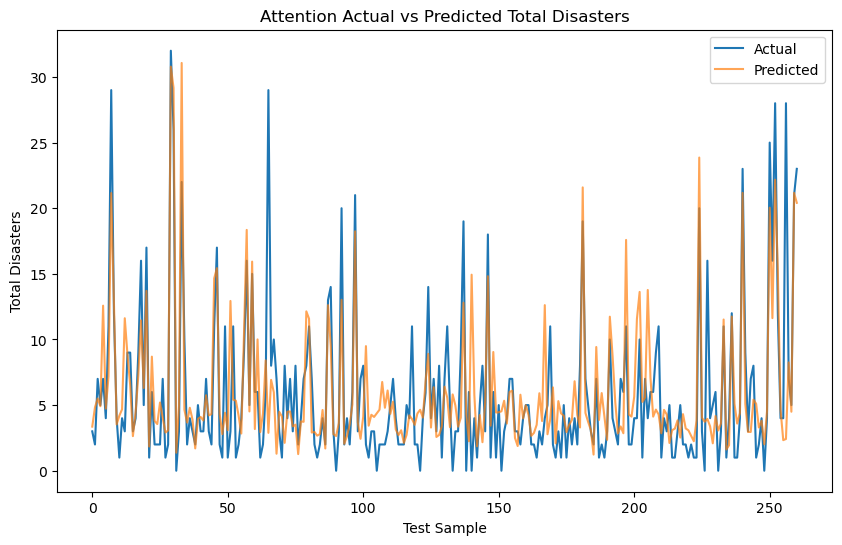

In [16]:
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual')
plt.plot(att_pred, label='Predicted', alpha=0.7)
plt.title('Attention Actual vs Predicted Total Disasters')
plt.xlabel('Test Sample')
plt.ylabel('Total Disasters')
plt.legend()
plt.show()

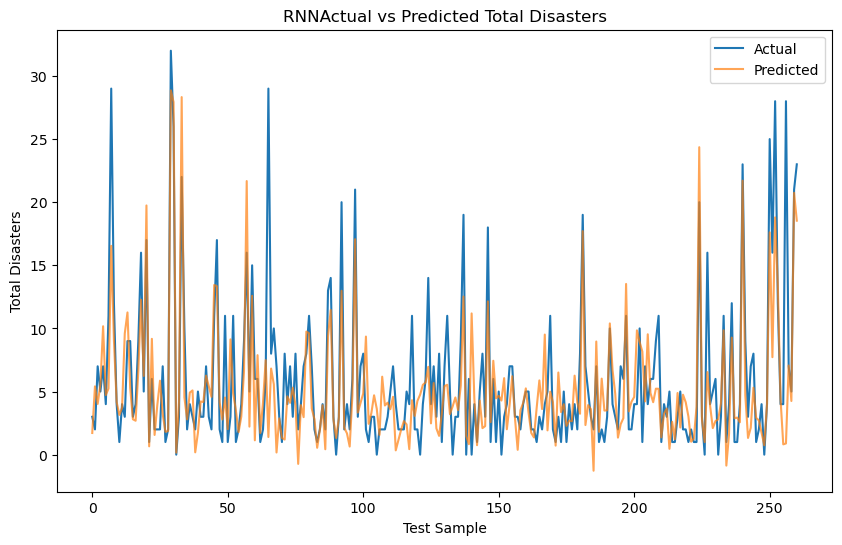

In [17]:
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual')
plt.plot(pred, label='Predicted', alpha=0.7)
plt.title('RNNActual vs Predicted Total Disasters')
plt.xlabel('Test Sample')
plt.ylabel('Total Disasters')
plt.legend()
plt.show()